In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import warnings

warnings.filterwarnings('ignore') # 경고 무시

%matplotlib inline

In [2]:
'''
데이터 불러오기
'''
original_data_df = pd.read_csv('./data/Sunspots.csv', index_col=0)

In [3]:
original_data_df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [4]:
original_data_df.shape

(3252, 2)

In [5]:
'''
데이터프레임 컬럼 이름 변경
'''
original_data_df.columns = ['Month', 'Sunspots']

In [6]:
original_data_df.head()

,Month,Sunspots
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [7]:
'''
날짜 datetime 타입으로 변환
'''
original_data_date_list = original_data_df['Month'].tolist()
original_data_date_list = pd.to_datetime(original_data_date_list)
original_data_df['Month'] = original_data_date_list

In [8]:
original_data_df.head()

,Month,Sunspots
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [9]:
type(original_data_df['Month'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
'''
Month 컬럼 인덱스 부여
'''
original_data_df = original_data_df.set_index('Month').astype(int) # Month 컬럼에 인덱스 부여

In [11]:
print(original_data_df.head())

            Sunspots
Month               
1749-01-31        96
1749-02-28       104
1749-03-31       116
1749-04-30        92
1749-05-31       141


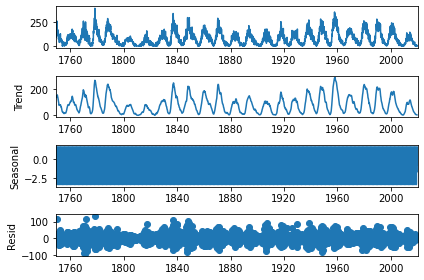

In [12]:
'''
statsmodels.tsa.seasonal - seasonal_decompose 분석 (trend, seasonal, resid)
'''

result = seasonal_decompose(original_data_df, model = 'additive')
re_plot = result.plot()
plt.show()

In [13]:
'''
trend, seasonal, resid 데이터 저장
'''
result_df = pd.DataFrame(
    {
        'Observed': result.observed, 
        'Trend': result.trend, 
        'Seasonal': result.seasonal, 
        'Resid': result.resid
    }
)
result_df.reset_index(level = 0, inplace = True)
result_df.dropna(axis = 0, inplace = True)
result_df.reset_index(drop = True, inplace = True)

In [14]:
result_df.head()

,Month,Observed,Trend,Seasonal,Resid
0,1749-07-31,158.0,135.500000,0.559697,21.940303
1,1749-08-31,110.0,137.500000,1.663555,-29.163555
2,1749-09-30,126.0,139.750000,1.185005,-14.935005
3,1749-10-31,125.0,143.375000,1.043956,-19.418956
4,1749-11-30,264.0,146.041667,-0.693236,118.651569


In [15]:
'''
특성간 상관관계

각 특성들은 종속적인 관계가 아닌 독립적인 요소
'''
result_df.corr()

,Observed,Trend,Seasonal,Resid
Observed,1.000000,0.947265,2.066681e-02,3.678280e-01
Trend,0.947265,1.000000,5.139659e-04,5.112784e-02
Seasonal,0.020667,0.000514,1.000000e+00,6.457226e-17
Resid,0.367828,0.051128,6.457226e-17,1.000000e+00


In [16]:
result_df.drop(['Observed'], axis = 1).corr()

,Trend,Seasonal,Resid
Trend,1.000000,5.139659e-04,5.112784e-02
Seasonal,0.000514,1.000000e+00,6.457226e-17
Resid,0.051128,6.457226e-17,1.000000e+00


<AxesSubplot:>

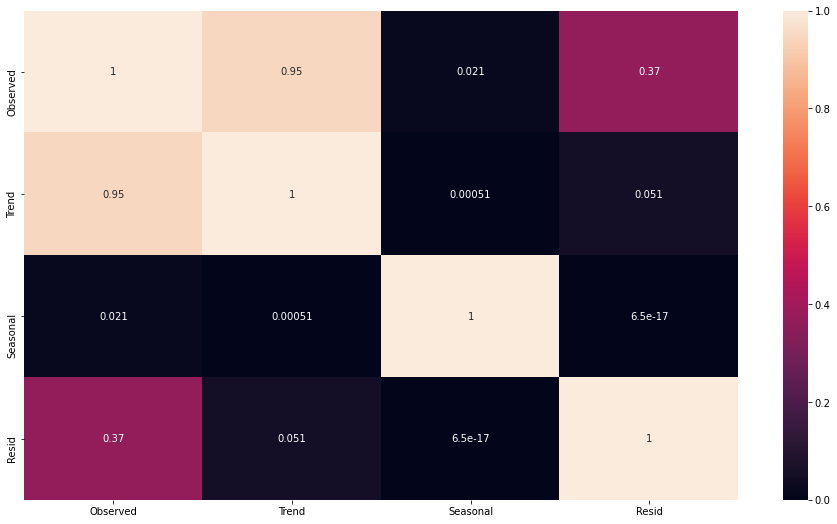

In [17]:
'''
seasonal 데이터는 매우 작은 영향을 미침
관측된 데이터에 대해서 Trend, Residual, Seasonal 순으로 영향을 미치는 정도가 다름
'''

plt.figure(figsize = (16, 9))
sns.heatmap(result_df.drop(['Month'], axis = 1).corr(), annot = True)

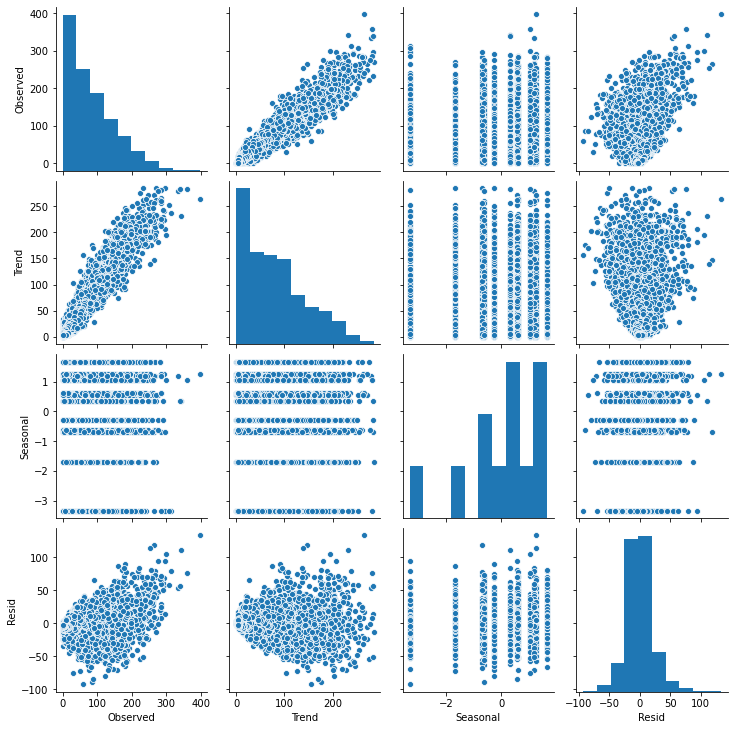

In [18]:
sns.pairplot(result_df)

In [19]:
'''
데이터간 독립성 확인
'''
result_df.head()

,Month,Observed,Trend,Seasonal,Resid
0,1749-07-31,158.0,135.500000,0.559697,21.940303
1,1749-08-31,110.0,137.500000,1.663555,-29.163555
2,1749-09-30,126.0,139.750000,1.185005,-14.935005
3,1749-10-31,125.0,143.375000,1.043956,-19.418956
4,1749-11-30,264.0,146.041667,-0.693236,118.651569


In [20]:
print(result_df['Trend'][0] + result_df['Seasonal'][0] + result_df['Resid'][0])
print(result_df['Trend'][1] + result_df['Seasonal'][1] + result_df['Resid'][1])
print(result_df['Trend'][2] + result_df['Seasonal'][2] + result_df['Resid'][2])

158.0
110.00000000000001
125.99999999999999


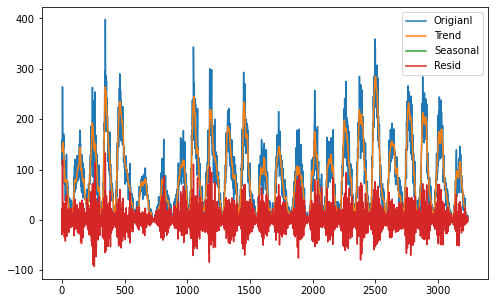

In [21]:
'''
decomposed data 시각화
'''
plt.figure(figsize = (8, 5))
plt.plot(result_df['Observed'], label = 'Origianl')
plt.plot(result_df['Trend'], label = 'Trend')
plt.plot(result_df['Seasonal'], label = 'Seasonal')
plt.plot(result_df['Resid'], label = 'Resid')
plt.legend(loc = 'upper right')
plt.show()

In [22]:
'''
날짜 하이픈 제거 및 데이터타입 변환
'''
result_df['Month'] = result_df['Month'].astype(str)
result_df['Month'] = result_df['Month'].str.replace(pat=r'[^\w\s]', repl=r'', regex=True) # 하이픈제거
result_df = result_df.astype('int')

In [23]:
result_df.head()

,Month,Observed,Trend,Seasonal,Resid
0,17490731,158,135,0,21
1,17490831,110,137,1,-29
2,17490930,126,139,1,-14
3,17491031,125,143,1,-19
4,17491130,264,146,0,118


In [24]:
'''
스케일링
'''
#scaler = MaxAbsScaler()
scaler = MinMaxScaler()
scaled_result_np = scaler.fit_transform(result_df)
#scaled_result_np = scaler.fit_transform(result_df)

In [25]:
'''
데이터프레임 재생성
'''
scaled_result_df = pd.DataFrame(scaled_result_np)
scaled_result_df.columns = ['Month', 'Observed', 'Trend', 'Seasonal', 'Resid']

In [26]:
scaled_result_df.head()

,Month,Observed,Trend,Seasonal,Resid
0,0.000000,0.396985,0.475352,0.75,0.504464
1,0.000037,0.276382,0.482394,1.00,0.281250
2,0.000074,0.316583,0.489437,1.00,0.348214
3,0.000111,0.314070,0.503521,1.00,0.325893
4,0.000148,0.663317,0.514085,0.75,0.937500


In [27]:
'''
train, test data 분리
'''
train_size = int(len(scaled_result_df) * 0.7)
train_data_df = scaled_result_df[0:train_size].reset_index(drop = True)
validation_data_df = scaled_result_df[:int(len(scaled_result_df) * 0.15):].reset_index(drop = True)
test_data_df = scaled_result_df[-int(len(scaled_result_df) * 0.15):].reset_index(drop = True)

In [28]:
print("train size:", train_size)
print("result df shape:", scaled_result_df.shape)
print("train df shape:", train_data_df.shape)
print("validation df shape:", validation_data_df.shape)
print("test df shape:", test_data_df.shape)

train size: 2268
result df shape: (3240, 5)
train df shape: (2268, 5)
validation df shape: (486, 5)
test df shape: (486, 5)


In [29]:
'''
input, label data 분리
'''
x_train_data_df = train_data_df[['Month', 'Trend', 'Seasonal', 'Resid']]
y_train_data_df = train_data_df[['Trend', 'Seasonal', 'Resid']]

x_validation_data_df = validation_data_df[['Month', 'Trend', 'Seasonal', 'Resid']]
y_validation_data_df = validation_data_df[['Trend', 'Seasonal', 'Resid']]

x_test_data_df = test_data_df[['Month', 'Trend', 'Seasonal', 'Resid']]
y_test_data_df = test_data_df[['Trend', 'Seasonal', 'Resid']]

In [30]:
print("x train shape:", x_train_data_df.shape)
print("y train shape:", y_train_data_df.shape)
print("x validation shape:", x_validation_data_df.shape)
print("y validation shape:", y_validation_data_df.shape)
print("x test shape", x_test_data_df.shape)
print("y test shape", y_test_data_df.shape)

x train shape: (2268, 4)
y train shape: (2268, 3)
x validation shape: (486, 4)
y validation shape: (486, 3)
x test shape (486, 4)
y test shape (486, 3)


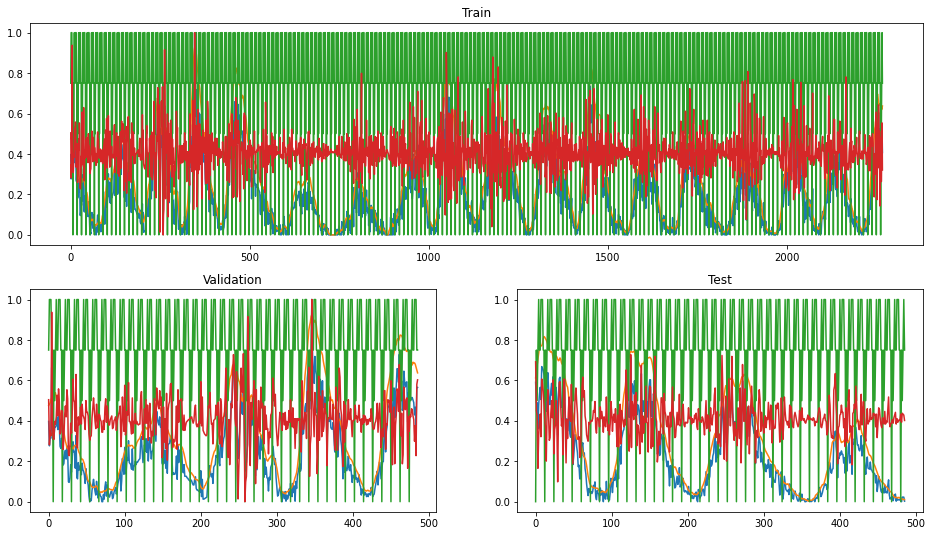

In [31]:
'''
scaled data 시각화
'''
plt.figure(figsize = (16, 9))

plt.subplot(211)
plt.plot(train_data_df.drop(['Month'], axis = 1))
plt.title('Train')

plt.subplot(223)
plt.plot(validation_data_df.drop(['Month'], axis = 1))
plt.title('Validation')

plt.subplot(224)
plt.plot(test_data_df.drop(['Month'], axis = 1))
plt.title('Test')

plt.show()

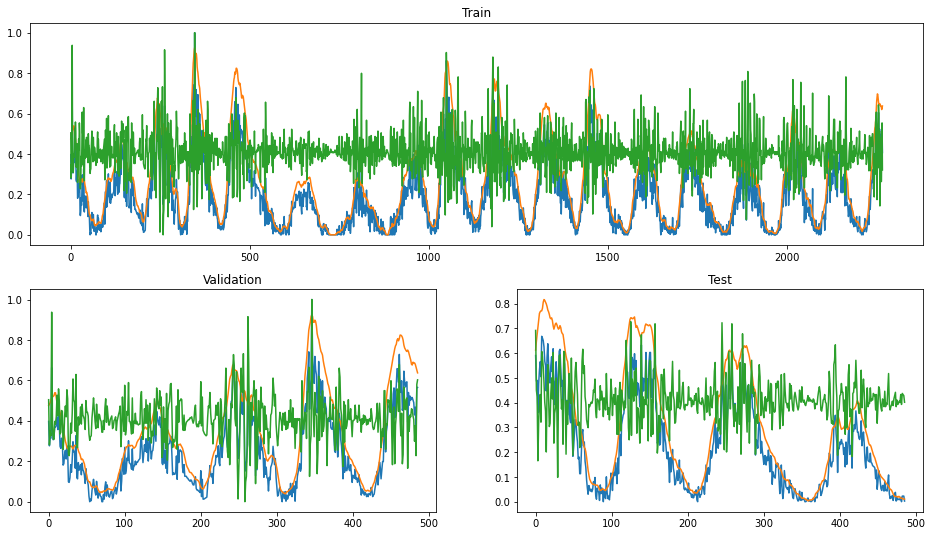

In [32]:
'''
가시성을 위해 seasonal data를 제거하고 시각화
'''
plt.figure(figsize = (16, 9))

plt.subplot(211)
plt.plot(train_data_df.drop(['Month', 'Seasonal'], axis = 1))
plt.title('Train')

plt.subplot(223)
plt.plot(validation_data_df.drop(['Month', 'Seasonal'], axis = 1))
plt.title('Validation')

plt.subplot(224)
plt.plot(test_data_df.drop(['Month', 'Seasonal'], axis = 1))
plt.title('Test')

plt.show()

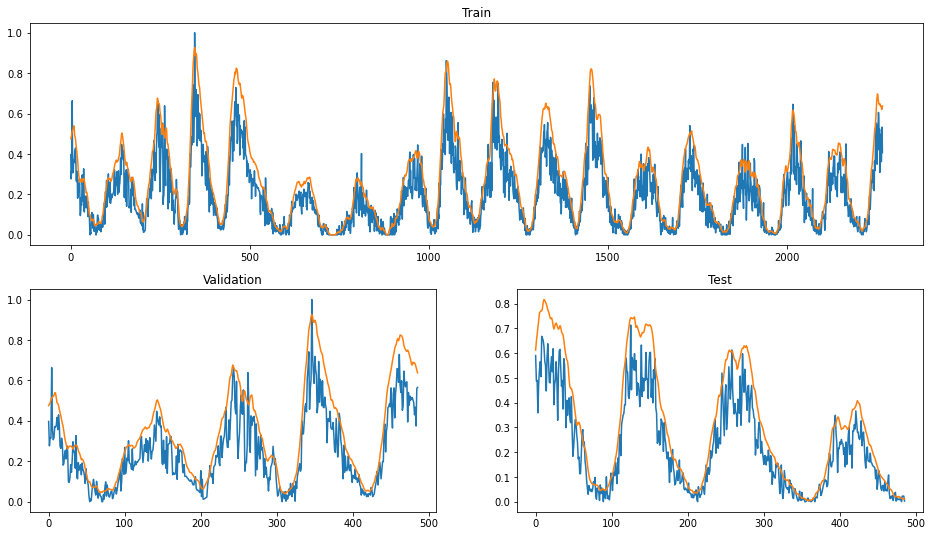

In [33]:
'''
가시성을 위해 seasonal data를 제거하고 시각화
'''
plt.figure(figsize = (16, 9))

plt.subplot(211)
plt.plot(train_data_df.drop(['Month', 'Seasonal', 'Resid'], axis = 1))
plt.title('Train')

plt.subplot(223)
plt.plot(validation_data_df.drop(['Month', 'Seasonal', 'Resid'], axis = 1))
plt.title('Validation')

plt.subplot(224)
plt.plot(test_data_df.drop(['Month', 'Seasonal', 'Resid'], axis = 1))
plt.title('Test')

plt.show()

In [34]:
'''
GPU 사용
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
print(device)

cuda


In [36]:
'''
랜덤시드 고정
'''
torch.manual_seed(777)

In [37]:
'''
하이퍼파라미터

입력 형태: (Batch Size, Sequence Length, Input Dimension)

태양 주기(태양 자기 활동 주기)는 태양 활동(태양 복사의 강도와 태양 물질의 분출에서의 변화를 포함)과 
태양의 겉표면(흑점의 개수, 플레어, 다른 가시적인 징후들)에서 보여지는 주기적인 변화를 말함
'''
batch_size = 11 # Sequence  태양 주기
sequence_length = 1 # 한 개의 batch 당 몇 개의 sequence가 들어있는 개수
input_size = 4 # 1개의 sequence의 내부에 4개의 데이터
hidden_size = 64
num_layers = 3
output_size = 3 # Trend, Seasonal, Residual
learning_rate = 1e-5
nb_epochs = 500

In [38]:
'''
데이터셋함수
'''
def MakeDataSet(x_data_df, y_data_df):
    x_ts = torch.FloatTensor(np.array(x_data_df))
    y_ts = torch.FloatTensor(np.array(y_data_df))
    dataset_ts = TensorDataset(x_ts, y_ts)

    return dataset_ts

'''
데이터로더
'''
def MakeDataLoader(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    return dataloader

In [39]:
'''
데이터셋
'''
train_dataset_ts = MakeDataSet(x_train_data_df, y_train_data_df)
validation_dataset_ts = MakeDataSet(x_validation_data_df, y_validation_data_df)
test_dataset_ts = MakeDataSet(x_test_data_df, y_test_data_df)

'''
데이터로더
'''
train_dataloader = MakeDataLoader(train_dataset_ts, batch_size)
validation_dataloader = MakeDataLoader(validation_dataset_ts, batch_size)
test_dataloader = MakeDataLoader(test_dataset_ts, batch_size)

In [40]:
'''
사용할 데이터 확인
'''
for i, samples in enumerate(test_dataloader):
    x, y = samples
    print("Batch:", i + 1)
    print("Input:",x.shape)
    print("Target:",y.shape)
    if i == 4:
        break

Batch: 1
Input: torch.Size([11, 4])
Target: torch.Size([11, 3])
Batch: 2
Input: torch.Size([11, 4])
Target: torch.Size([11, 3])
Batch: 3
Input: torch.Size([11, 4])
Target: torch.Size([11, 3])
Batch: 4
Input: torch.Size([11, 4])
Target: torch.Size([11, 3])
Batch: 5
Input: torch.Size([11, 4])
Target: torch.Size([11, 3])


In [41]:

'''
model 설계
'''
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = 0.3,
            batch_first = True
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size,
            bias = True
        )

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [42]:
'''
model, cost, optimizer
'''
model = Net(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [43]:
'''
모델 테스트
'''
x, y = list(train_dataloader)[0]
x = x.view(-1, sequence_length, input_size).to(device) # RNN input: batch size, sequence length, input size
y = y.to(device)
hypothesis = model(x)
loss = criterion(hypothesis, y)

In [44]:
print("X shape:", x, x.shape)
print("Y shape:", y.shape)
print("Hypothesis:", hypothesis)
print("Optimizer:", optimizer)
print("Loss:", loss)

X shape: tensor([[[0.6815, 0.0317, 0.7500, 0.4018]],

        [[0.5779, 0.3521, 0.7500, 0.7589]],

        [[0.3000, 0.4049, 1.0000, 0.2634]],

        [[0.6407, 0.0845, 1.0000, 0.3571]],

        [[0.0890, 0.2254, 0.7500, 0.4286]],

        [[0.5076, 0.0845, 0.7500, 0.3080]],

        [[0.5889, 0.2923, 1.0000, 0.6964]],

        [[0.5110, 0.0669, 0.7500, 0.3795]],

        [[0.4851, 0.1725, 1.0000, 0.3616]],

        [[0.6295, 0.4085, 0.7500, 0.2768]],

        [[0.0519, 0.2641, 0.7500, 0.4732]]], device='cuda:0') torch.Size([11, 1, 4])
Y shape: torch.Size([11, 3])
Hypothesis: tensor([[-0.0260, -0.0802,  0.0535],
        [-0.0250, -0.0808,  0.0522],
        [-0.0246, -0.0835,  0.0512],
        [-0.0244, -0.0814,  0.0495],
        [-0.0244, -0.0835,  0.0522],
        [-0.0223, -0.0833,  0.0499],
        [-0.0277, -0.0789,  0.0517],
        [-0.0243, -0.0816,  0.0519],
        [-0.0221, -0.0811,  0.0492],
        [-0.0248, -0.0799,  0.0516],
        [-0.0258, -0.0816,  0.0486]], device=

In [45]:
for i, samples in enumerate(train_dataloader):
    x, y = samples
    print(i + 1)
    x = x.view(-1, sequence_length, input_size).to(device)
    y = y.to(device)
    print(x)
    if i == 4:
        break

1
tensor([[[0.5443, 0.2782, 0.5000, 0.4464]],

        [[0.2888, 0.2958, 1.0000, 0.4420]],

        [[0.0039, 0.4261, 0.7500, 0.3438]],

        [[0.6408, 0.0775, 0.7500, 0.3884]],

        [[0.6000, 0.0317, 0.7500, 0.3839]],

        [[0.4778, 0.0176, 0.7500, 0.3884]],

        [[0.3703, 0.6549, 0.7500, 0.2679]],

        [[0.4039, 0.5000, 0.7500, 0.3393]],

        [[0.4149, 0.4613, 1.0000, 0.3884]],

        [[0.3221, 0.6162, 0.5000, 0.3661]],

        [[0.2259, 0.0000, 0.7500, 0.4107]]], device='cuda:0')
2
tensor([[[0.4481, 0.7817, 1.0000, 0.7143]],

        [[0.6816, 0.0176, 1.0000, 0.4152]],

        [[0.1296, 0.0563, 0.7500, 0.3839]],

        [[0.4890, 0.3451, 1.0000, 0.4420]],

        [[0.0296, 0.1620, 1.0000, 0.4732]],

        [[0.3925, 0.0599, 1.0000, 0.4062]],

        [[0.0743, 0.6514, 0.7500, 0.4107]],

        [[0.5888, 0.2993, 0.7500, 0.4554]],

        [[0.6150, 0.3310, 0.7500, 0.3080]],

        [[0.1925, 0.1620, 0.5000, 0.4286]],

        [[0.1706, 0.1127, 0.7500, 

In [46]:
'''
학습
'''
train_loss_list = []
val_loss_list = []
predicted_data_list = []
original_label_list = []
for epoch in range(nb_epochs):
    for i, samples in enumerate(train_dataloader):
        tr_loss = 0.0
        x_train, y_train = samples
        x_train = x_train.view(-1, sequence_length, input_size).to(device)
        y_train = y_train.to(device)
        
        model.train()
        hypothesis = model(x_train)
        optimizer.zero_grad()
        train_loss = criterion(hypothesis, y_train)
        train_loss.backward()
        optimizer.step()
        
        tr_loss += train_loss.item()
        
    with torch.no_grad():
        for ii, validation_samples in enumerate(validation_dataloader):
            val_loss = 0.0
            x_validation, y_validation = validation_samples
            x_validation = x_validation.view(-1, sequence_length, input_size).to(device)
            y_validation = y_validation.to(device)
                
            model.eval()
            prediction = model(x_validation)
            validation_loss = criterion(prediction, y_validation)
            
            val_loss += validation_loss.item()
                
        predicted_data_list.append(prediction.tolist())
        original_label_list.append(y_validation.tolist())
                
    train_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print("Epoch: {} | Train Loss: {:.6f} | Val Loss: {:.6f}".format(epoch + 1, tr_loss, val_loss))
    
    if epoch > 500: 
        if tr_loss and val_loss < 0.002:
            break
        break

torch.save(model, './data/model.pt')

Epoch: 1 | Train Loss: 0.254980 | Val Loss: 0.363020
Epoch: 2 | Train Loss: 0.360439 | Val Loss: 0.346109
Epoch: 3 | Train Loss: 0.332469 | Val Loss: 0.463992
Epoch: 4 | Train Loss: 0.407407 | Val Loss: 0.265620
Epoch: 5 | Train Loss: 0.316214 | Val Loss: 0.311847
Epoch: 6 | Train Loss: 0.288921 | Val Loss: 0.165065
Epoch: 7 | Train Loss: 0.236059 | Val Loss: 0.293248
Epoch: 8 | Train Loss: 0.181399 | Val Loss: 0.408028
Epoch: 9 | Train Loss: 0.184440 | Val Loss: 0.262187
Epoch: 10 | Train Loss: 0.226199 | Val Loss: 0.319903
Epoch: 11 | Train Loss: 0.201200 | Val Loss: 0.260979
Epoch: 12 | Train Loss: 0.259300 | Val Loss: 0.251382
Epoch: 13 | Train Loss: 0.066687 | Val Loss: 0.146717
Epoch: 14 | Train Loss: 0.117242 | Val Loss: 0.135741
Epoch: 15 | Train Loss: 0.046242 | Val Loss: 0.059321
Epoch: 16 | Train Loss: 0.093317 | Val Loss: 0.062557
Epoch: 17 | Train Loss: 0.064350 | Val Loss: 0.028191
Epoch: 18 | Train Loss: 0.022025 | Val Loss: 0.068019
Epoch: 19 | Train Loss: 0.033127 | Va

Epoch: 152 | Train Loss: 0.057592 | Val Loss: 0.049531
Epoch: 153 | Train Loss: 0.039157 | Val Loss: 0.016091
Epoch: 154 | Train Loss: 0.017919 | Val Loss: 0.016511
Epoch: 155 | Train Loss: 0.016681 | Val Loss: 0.003792
Epoch: 156 | Train Loss: 0.022704 | Val Loss: 0.006192
Epoch: 157 | Train Loss: 0.034192 | Val Loss: 0.041207
Epoch: 158 | Train Loss: 0.006388 | Val Loss: 0.063483
Epoch: 159 | Train Loss: 0.020935 | Val Loss: 0.005452
Epoch: 160 | Train Loss: 0.012136 | Val Loss: 0.021745
Epoch: 161 | Train Loss: 0.041153 | Val Loss: 0.011778
Epoch: 162 | Train Loss: 0.017105 | Val Loss: 0.011653
Epoch: 163 | Train Loss: 0.014971 | Val Loss: 0.003434
Epoch: 164 | Train Loss: 0.010476 | Val Loss: 0.009560
Epoch: 165 | Train Loss: 0.030027 | Val Loss: 0.056837
Epoch: 166 | Train Loss: 0.030037 | Val Loss: 0.041917
Epoch: 167 | Train Loss: 0.071611 | Val Loss: 0.006771
Epoch: 168 | Train Loss: 0.022497 | Val Loss: 0.028155
Epoch: 169 | Train Loss: 0.011298 | Val Loss: 0.043917
Epoch: 170

Epoch: 301 | Train Loss: 0.005419 | Val Loss: 0.004522
Epoch: 302 | Train Loss: 0.002521 | Val Loss: 0.006834
Epoch: 303 | Train Loss: 0.022353 | Val Loss: 0.005851
Epoch: 304 | Train Loss: 0.003343 | Val Loss: 0.008544
Epoch: 305 | Train Loss: 0.053758 | Val Loss: 0.004022
Epoch: 306 | Train Loss: 0.002493 | Val Loss: 0.003187
Epoch: 307 | Train Loss: 0.008537 | Val Loss: 0.003958
Epoch: 308 | Train Loss: 0.001918 | Val Loss: 0.004579
Epoch: 309 | Train Loss: 0.010148 | Val Loss: 0.011632
Epoch: 310 | Train Loss: 0.006491 | Val Loss: 0.002431
Epoch: 311 | Train Loss: 0.006239 | Val Loss: 0.004485
Epoch: 312 | Train Loss: 0.004556 | Val Loss: 0.001105
Epoch: 313 | Train Loss: 0.005657 | Val Loss: 0.004113
Epoch: 314 | Train Loss: 0.011523 | Val Loss: 0.002063
Epoch: 315 | Train Loss: 0.002550 | Val Loss: 0.006344
Epoch: 316 | Train Loss: 0.016922 | Val Loss: 0.002224
Epoch: 317 | Train Loss: 0.005129 | Val Loss: 0.006147
Epoch: 318 | Train Loss: 0.011124 | Val Loss: 0.003328
Epoch: 319

Epoch: 450 | Train Loss: 0.001157 | Val Loss: 0.000641
Epoch: 451 | Train Loss: 0.004064 | Val Loss: 0.002664
Epoch: 452 | Train Loss: 0.009688 | Val Loss: 0.003503
Epoch: 453 | Train Loss: 0.001490 | Val Loss: 0.011067
Epoch: 454 | Train Loss: 0.001991 | Val Loss: 0.006224
Epoch: 455 | Train Loss: 0.006112 | Val Loss: 0.003939
Epoch: 456 | Train Loss: 0.005019 | Val Loss: 0.005605
Epoch: 457 | Train Loss: 0.001476 | Val Loss: 0.000511
Epoch: 458 | Train Loss: 0.003141 | Val Loss: 0.006649
Epoch: 459 | Train Loss: 0.004924 | Val Loss: 0.001045
Epoch: 460 | Train Loss: 0.002003 | Val Loss: 0.005662
Epoch: 461 | Train Loss: 0.007906 | Val Loss: 0.000570
Epoch: 462 | Train Loss: 0.001897 | Val Loss: 0.001512
Epoch: 463 | Train Loss: 0.010503 | Val Loss: 0.000144
Epoch: 464 | Train Loss: 0.001642 | Val Loss: 0.000690
Epoch: 465 | Train Loss: 0.002434 | Val Loss: 0.001918
Epoch: 466 | Train Loss: 0.005432 | Val Loss: 0.034919
Epoch: 467 | Train Loss: 0.025763 | Val Loss: 0.000201
Epoch: 468

In [47]:
print("train loss list length:", len(train_loss_list))
print("validation loss list length:", len(val_loss_list))
print("predicted data list:", len(predicted_data_list))
print("original label list:", len(original_label_list))

train loss list length: 500
validation loss list length: 500
predicted data list: 500
original label list: 500


In [48]:
'''
결과 데이터 저장
'''
loss_result_df = pd.DataFrame({'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})
label_result_df = pd.DataFrame({'Predicted Data': predicted_data_list, 'Original Label': original_label_list})

loss_result_df.to_csv('./data/loss_result_df.csv')
label_result_df.to_csv('./data/label_result_df.csv')

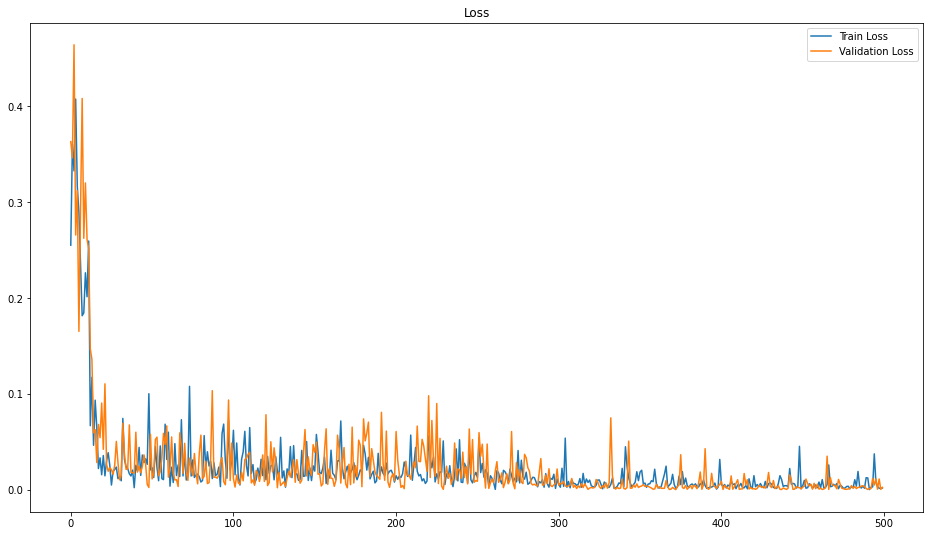

In [49]:
'''
train, validation loss 시각화
'''
plt.figure(figsize = (16, 9))
plt.plot(train_loss_list, label = 'Train Loss')
plt.plot(val_loss_list, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Loss')
plt.show()

In [50]:
'''
label 데이터 차원 축소
'''
predicted_data_np = np.array(sum(sum(predicted_data_list, []), []))
original_label_np = np.array(sum(sum(original_label_list, []), []))

In [51]:
'''
데이터 비교
'''
predicted_data_df = pd.DataFrame(predicted_data_np.reshape(-1, 3))
predicted_data_df.columns = ['Predicted Trend', 'Predicted Seasonal', 'Predicted Resid']

original_label_df = pd.DataFrame(original_label_np.reshape(-1, 3))
original_label_df.columns = ['Original Trend', 'Original Seasonal', 'Original Resid']

In [52]:
predicted_data_df.head()

,Predicted Trend,Predicted Seasonal,Predicted Resid
0,-0.018937,-0.070511,0.058997
1,-0.018903,-0.070335,0.059143
2,-0.012530,-0.059205,0.067016
3,-0.012543,-0.058987,0.067197
4,-0.005867,-0.047007,0.075464


In [53]:
original_label_df.head()

,Original Trend,Original Seasonal,Original Resid
0,0.309859,0.75,0.383929
1,0.686620,0.75,0.406250
2,0.440141,0.50,0.254464
3,0.774648,0.75,0.566964
4,0.422535,1.00,0.549107


In [54]:
'''
결과 데이터 데이터프레임 생성
'''
sum_predicted_data_df = pd.DataFrame({'Predicted Data': predicted_data_df.sum(axis = 1)})
sum_original_label_df = pd.DataFrame({'Original Data': original_label_df.sum(axis = 1)})

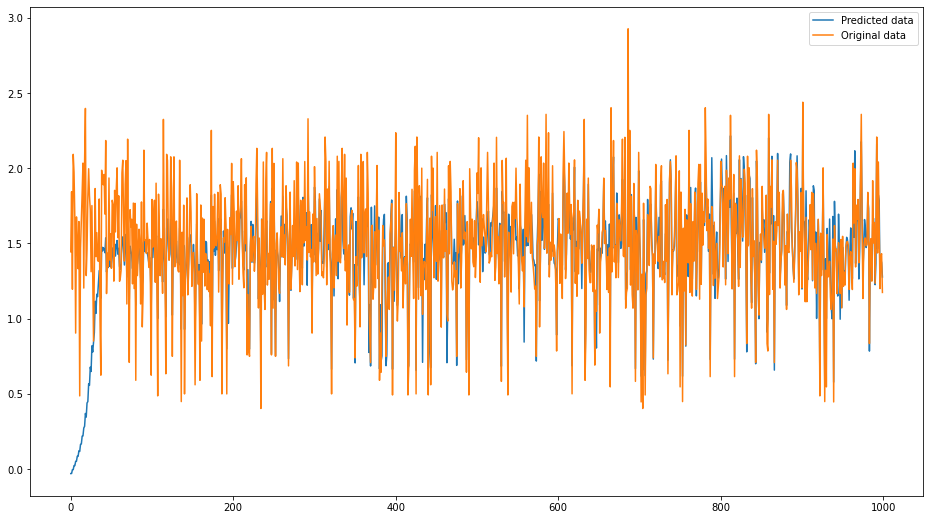

In [101]:
'''
결과 데이터 시각화
'''
plt.figure(figsize = (16, 9))
plt.plot(sum_predicted_data_df, label = 'Predicted data')
plt.plot(sum_original_label_df, label = 'Original data')
plt.legend(loc = 'upper right')
plt.show()

In [83]:
'''
결과 데이터 데이터프레임 결합
'''
reshaped_predicted_data_df = pd.concat([x_validation_data_df['Month'], sum_predicted_data_df['Predicted Data'][:len(x_validation_data_df)], predicted_data_df[:len(x_validation_data_df)]], axis = 1)
reshaped_original_label_df = pd.concat([x_validation_data_df['Month'], sum_original_label_df['Original Data'][:len(x_validation_data_df)], original_label_df[:len(x_validation_data_df)]], axis = 1)

In [84]:
reshaped_predicted_data_df

,Month,Predicted Data,Predicted Trend,Predicted Seasonal,Predicted Resid
0,0.000000,-0.030452,-0.018937,-0.070511,0.058997
1,0.000037,-0.030095,-0.018903,-0.070335,0.059143
2,0.000074,-0.004719,-0.012530,-0.059205,0.067016
3,0.000111,-0.004332,-0.012543,-0.058987,0.067197
4,0.000148,0.022590,-0.005867,-0.047007,0.075464
...,...,...,...,...,...
481,0.148191,1.462279,0.273948,0.771874,0.416458
482,0.148227,1.814541,0.342905,1.060412,0.411224
483,0.148265,1.488889,0.284606,0.783848,0.420436
484,0.148301,1.498270,0.285726,0.794112,0.418432


In [85]:
reshaped_original_label_df

,Month,Original Data,Original Trend,Original Seasonal,Original Resid
0,0.000000,1.443788,0.309859,0.75,0.383929
1,0.000037,1.842870,0.686620,0.75,0.406250
2,0.000074,1.194605,0.440141,0.50,0.254464
3,0.000111,2.091612,0.774648,0.75,0.566964
4,0.000148,1.971642,0.422535,1.00,0.549107
...,...,...,...,...,...
481,0.148191,1.382168,0.373239,0.75,0.258929
482,0.148227,1.788670,0.605634,1.00,0.183036
483,0.148265,1.916373,0.478873,0.75,0.687500
484,0.148301,1.528672,0.492958,0.75,0.285714


In [86]:
'''
예측 데이터 데이터프레임 변환
'''
inversed_predicted_data_np = scaler.inverse_transform(reshaped_predicted_data_df)
inversed_predicted_data_df = pd.DataFrame(inversed_predicted_data_np)

'''
레이블 데이터 데이터프레임 변환
'''
inversed_original_label_np = scaler.inverse_transform(reshaped_original_label_df)
inversed_original_label_df = pd.DataFrame(inversed_original_label_np)

In [88]:
'''
데이터프레임 컬럼 네임 변경
'''
inversed_predicted_data_df.columns = [
    'Predicted Month', 
    'Predicted Observed', 
    'Predicted Trend', 
    'Predicted Seasonal', 
    'Predicted Resid'
]

inversed_original_label_df.columns = [
    'Original Month', 
    'Original Observed', 
    'Original Trend', 
    'Original Seasonal', 
    'Original Resid'
]

In [89]:
'''
데이터프레임 데이터 타입 변환
'''
inversed_predicted_data_df = inversed_predicted_data_df.round(0)#.astype(int)
inversed_predicted_data_df['Predicted Month'] = inversed_predicted_data_df['Predicted Month'].astype(str)

inversed_original_label_df = inversed_original_label_df.round(0)#.astype(int)
inversed_original_label_df['Original Month'] = inversed_original_label_df['Original Month'].astype(str)

In [93]:
inversed_predicted_data_df[-10:]

,Predicted Month,Predicted Observed,Predicted Trend,Predicted Seasonal,Predicted Resid
476,17890331.0,709.0,94.0,1.0,-0.0
477,17890430.0,490.0,71.0,-1.0,2.0
478,17890531.0,572.0,75.0,0.0,1.0
479,17890630.0,612.0,85.0,0.0,2.0
480,17890731.0,544.0,69.0,-0.0,0.0
481,17890831.0,582.0,78.0,0.0,1.0
482,17890930.0,722.0,97.0,1.0,0.0
483,17891031.0,593.0,81.0,0.0,2.0
484,17891130.0,596.0,81.0,0.0,2.0
485,17891231.0,670.0,84.0,1.0,-1.0


In [94]:
inversed_original_label_df[-10:]

,Original Month,Original Observed,Original Trend,Original Seasonal,Original Resid
476,17890331.0,702.0,137.0,1.0,-29.0
477,17890430.0,572.0,153.0,-1.0,-3.0
478,17890531.0,611.0,81.0,0.0,20.0
479,17890630.0,742.0,178.0,0.0,17.0
480,17890731.0,479.0,17.0,0.0,-4.0
481,17890831.0,550.0,106.0,0.0,-34.0
482,17890930.0,712.0,172.0,1.0,-51.0
483,17891031.0,763.0,136.0,0.0,62.0
484,17891130.0,608.0,140.0,0.0,-28.0
485,17891231.0,627.0,52.0,1.0,-4.0


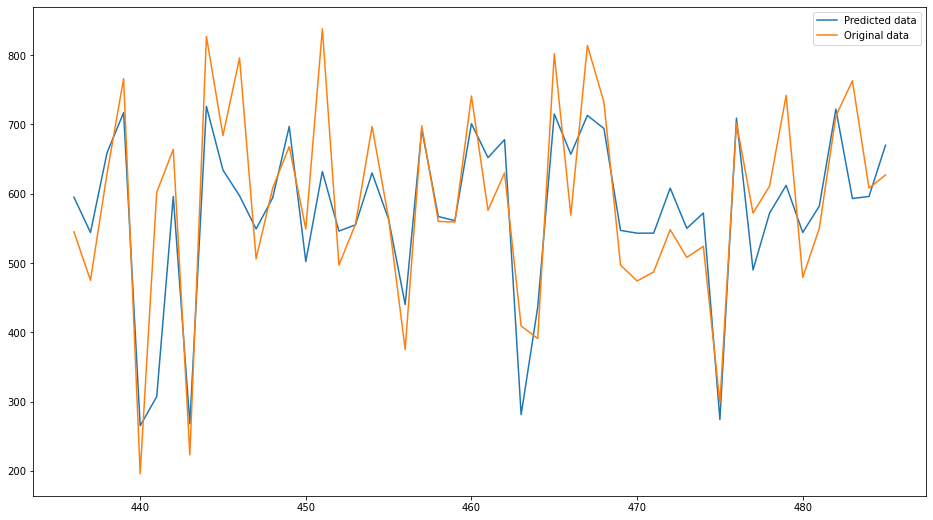

In [105]:
'''
뒷 부분 데이터 출력
'''
plt.figure(figsize = (16, 9))
plt.plot(inversed_predicted_data_df[-50:]['Predicted Observed'], label = 'Predicted data')
plt.plot(inversed_original_label_df[-50:]['Original Observed'], label = 'Original data')
plt.legend(loc = 'upper right')
plt.show()

[]

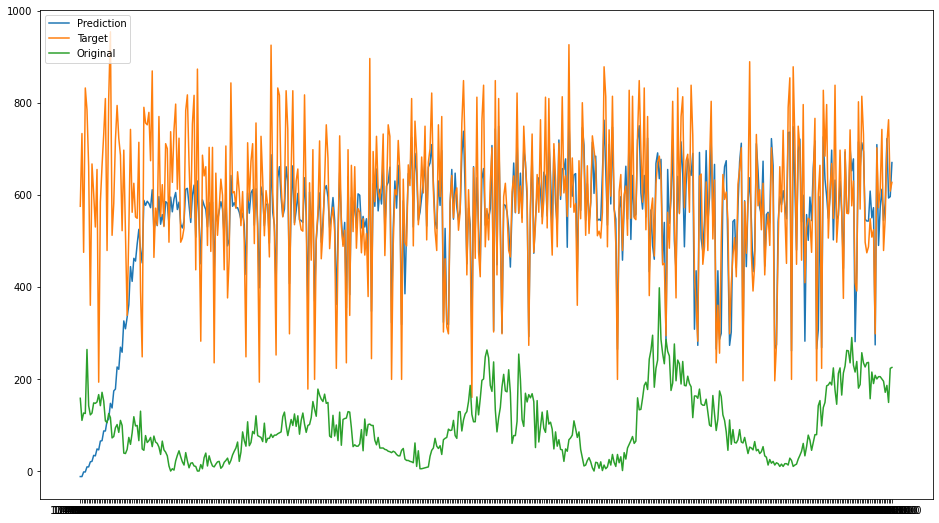

In [118]:
'''
결과 데이터 시각화
'''
plt.figure(figsize = (16, 9))
plt.plot(inversed_predicted_data_df['Predicted Month'], inversed_predicted_data_df['Predicted Observed'][:len(x_validation_data_df)], label = 'Prediction')
plt.plot(inversed_original_label_df['Original Month'], inversed_original_label_df['Original Observed'][:len(x_validation_data_df)], label = 'Target')
plt.plot(inversed_original_label_df['Original Month'], result_df['Observed'][:int(len(scaled_result_df) * 0.15):], label = 'Original') # 실제로 원래 나와야하는 값
plt.legend(loc = 'upper left')
plt.plot()

In [107]:
'''
모델 평가
'''
with torch.no_grad():
    test_result_data_list = []
    test_result_label_list = []
    for i, samples in enumerate(test_dataloader):
        x_test, y_test = samples
        x_test = x_test.view(-1, sequence_length, input_size).to(device)
        y_test = y_test.to(device)
        
        prediction = model(x_test)
        test_result_data_list.append(prediction.tolist())
        test_result_label_list.append(y_test.tolist())#.cpu().data.numpy())
        loss = criterion(prediction, y_test)

In [126]:
'''
label 데이터 차원 축소
'''
test_result_data_np = np.array(sum(sum(test_result_data_list, []), []))
test_result_label_np = np.array(sum(sum(test_result_label_list, []), []))

'''
데이터프레임 reshape, columns 설정
'''
test_result_data_df = pd.DataFrame(test_result_data_np.reshape(-1, 3))
test_result_data_df.columns = ['Predicted Trend', 'Predicted Seasonal', 'Predicted Resid']

test_result_label_df = pd.DataFrame(test_result_label_np.reshape(-1, 3))
test_result_label_df.columns = ['Predicted Trend', 'Predicted Seasonal', 'Predicted Resid']

'''
결과 데이터 데이터프레임 생성
'''
sum_test_result_data_df = pd.DataFrame({'Predicted Data': test_result_data_df.sum(axis = 1)})
sum_test_result_label_df = pd.DataFrame({'Original Data': test_result_label_df.sum(axis = 1)})

'''
결과 데이터 데이터프레임 결합
'''
reshaped_test_result_data_df = pd.concat([x_test_data_df['Month'], sum_test_result_data_df['Predicted Data'], test_result_data_df], axis = 1)
reshaped_test_result_label_df = pd.concat([x_test_data_df['Month'], sum_test_result_label_df['Original Data'], test_result_label_df], axis = 1)

'''
예측 데이터 데이터프레임 변환
'''
inversed_test_result_data_np = scaler.inverse_transform(reshaped_test_result_data_df)
inversed_test_result_data_df = pd.DataFrame(inversed_predicted_data_np)

'''
레이블 데이터 데이터프레임 변환
'''
inversed_test_result_label_np = scaler.inverse_transform(reshaped_test_result_label_df)
inversed_test_result_label_df = pd.DataFrame(inversed_original_label_np)

'''
데이터프레임 컬럼 네임 변경
'''
inversed_test_result_data_df.columns = [
    'Predicted Month', 
    'Predicted Data', 
    'Predicted Trend', 
    'Predicted Seasonal', 
    'Predicted Resid'
]

inversed_test_result_label_df.columns = [
    'Original Month', 
    'Original Data', 
    'Original Trend', 
    'Original Seasonal', 
    'Original Resid'
]

'''
데이터프레임 데이터 타입 변환
'''
inversed_test_result_data_df = inversed_test_result_data_df.round(0)#.astype(int)
inversed_test_result_data_df['Predicted Month'] = inversed_test_result_data_df['Predicted Month'].astype(str)

inversed_test_result_label_df = inversed_test_result_label_df.round(0)#.astype(int)
inversed_test_result_label_df['Original Month'] = inversed_test_result_label_df['Original Month'].astype(str)

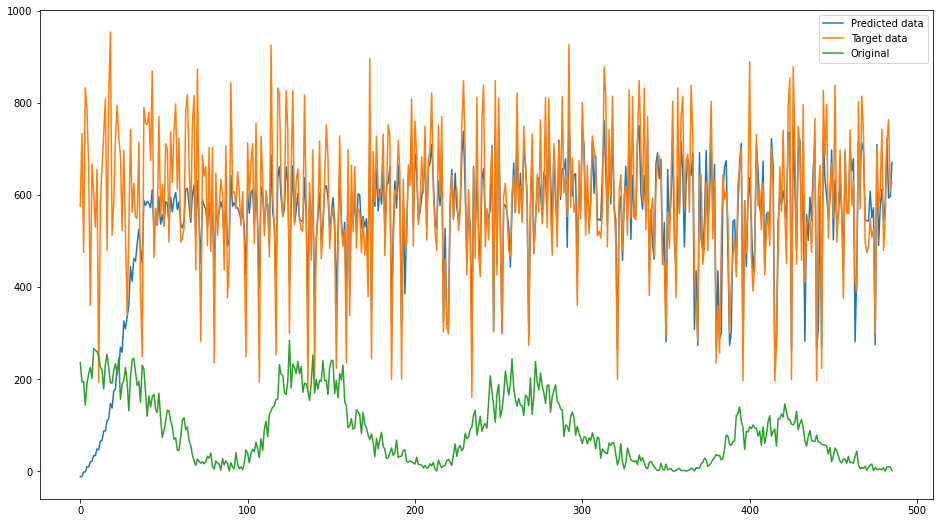

In [131]:
'''
뒷 부분 데이터 출력
'''
plt.figure(figsize = (16, 9))
plt.plot(inversed_test_result_data_df['Predicted Data'], label = 'Predicted data')
plt.plot(inversed_test_result_label_df['Original Data'], label = 'Target data')
plt.plot(result_df['Observed'][-int(len(scaled_result_df) * 0.15):].reset_index(drop = True), label = 'Original') # 실제로 원래 나와야하는 값
plt.legend(loc = 'upper right')
plt.show()